In [1]:
from importlib import reload
from tfoptym.mathops import set_backend_to_jax,set_backend_to_numpy,compute_eigenvalues_2x2
from tfoptym.thinfilms import compute_thin_films_byu, compute_thin_films_broadcasted, c_plate_jones
import numpy as np
from astropy.io import fits

# make pretty pictures
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# set backend shim
set_backend_to_numpy()

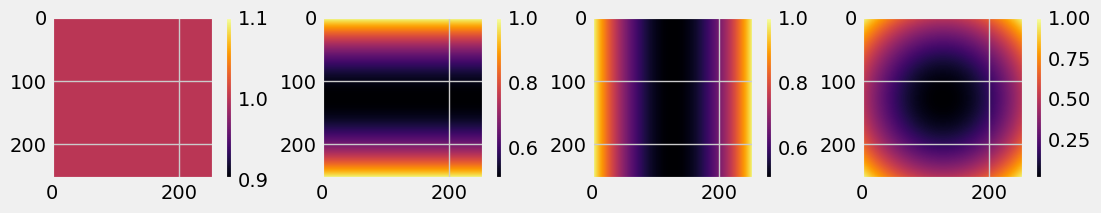

In [37]:
# Try the polynomial computation
from tfoptym.polynomials import gen_positive_polynomial_basis
cmplx_basis = gen_positive_polynomial_basis(nterms=4)

plt.figure(figsize=[15,2])
for i,func in enumerate(cmplx_basis):
    plt.subplot(1,len(cmplx_basis)+1,i+1)
    plt.imshow(np.abs(func),cmap='inferno')
    plt.colorbar()
plt.subplots_adjust()
plt.show()

# from prysm.polynomials import zernike_nm_sequence,noll_to_nm,sum_of_2d_modes,Q2d_sequence
# from prysm.coordinates import cart_to_polar, make_xy_grid
# x,y = make_xy_grid(256,diameter=2)
# r,t = cart_to_polar(x,y)
# nms = [noll_to_nm(j) for j in range(1,6)]
# basis = list(zernike_nm_sequence(nms,r,t))
# plt.figure(figsize=[15,2])
# for i,func in enumerate(basis):
#     plt.subplot(1,len(basis)+1,i+1)
#     plt.imshow(np.abs(func),cmap='inferno')
#     plt.colorbar()
# plt.subplots_adjust()
# plt.show()

# cmplx_basis = [np.complex128(mode) for mode in basis]


In [97]:
import tfoptym.thinfilms
reload(tfoptym.thinfilms)

def compute_diattenuation_retardance_transmission(jones):

    e1,e2 = compute_eigenvalues_2x2(jones)
    T = (np.abs(e1)**2 +np.abs(e2)**2)
    D = (np.abs(e1)**2 - np.abs(e2)**2) / T
    R = np.angle(e1) - np.angle(e2)

    return D,R,T

    

def cost_function(a,jones,basis,aoi,wavelength,indices,return_jones=False):
    """the function to differentiate with respect to the coefficient vector

    Parameters
    ----------
    a : 1D numpy.ndarray
        vector to pass to scipy.optimize.minimize. Is necesarilly a vector, but will
        be reshaped into an array of shape [nlayers,nmodes].

    jones : numpy array of shape N,N,npix,npix
        jones pupil to optimize

    basis : list of numpy arrays
        list of arrays representing the fundamental shapes of our film thickness basis

    aoi : float
        angle of incidence, radians, on the thin film stack

    wavelength : float
        wavelength of light to trace

    indices : list of floats
        stack of [n1,n2,n3,n4] containing refractive index information


    Returns
    -------
    cost
    """

    # figure out what shape a needs to be and reshape
    nmodes = len(basis)
    nlayers = int(a.shape[0]/nmodes)
    a = a.reshape([nlayers,nmodes])

    # create the film thicknesses
    film_thickness = np.zeros(basis[0].shape)
    thickness_list = []

    # add basis layers
    for layer in range(nlayers):
    #     coeffs = a[layer]
    #     thickness_list.append(sum_of_2d_modes(basis,coeffs))

        for i,mode in enumerate(basis):
            film_thickness = film_thickness + a[layer,i]*mode

        thickness_list.append(film_thickness)
        film_thickness = np.zeros(basis[0].shape)

    # construct the stack
    stack = []
    for n,d in zip(indices,thickness_list):
        stack.append((n,d))

    # compute Fresnel coefficients
    # fs,_ = compute_thin_films_broadcasted(stack, aoi, wavelength, ambient_index=1, substrate_index=0.050000 + 1j*3.1309, polarization='s')
    # fp,_ = compute_thin_films_broadcasted(stack, aoi, wavelength, ambient_index=1, substrate_index=0.050000 + 1j*3.1309, polarization='s')
    # store in thin film jones pupil
    thin_jones = np.zeros_like(jones)

    # accomodate for a jax quirk
    # if np.__name__ == 'jax.numpy':
    #     thin_jones = thin_jones.at[...,0,0].set(fs)
    #     thin_jones = thin_jones.at[...,1,1].set(fp)
    # else:
    #     thin_jones[...,0,0] = fs
    #     thin_jones[...,1,1] = fp

    thin_jones = c_plate_jones(aoi,1.6585,1.4862,wavelength,thickness_list[0])

    total_jones = thin_jones @ jones

    D,R,T = compute_diattenuation_retardance_transmission(total_jones)
    # for data in [D,R,T]:
    #     plt.figure()
    #     plt.imshow(data)
    #     plt.show()
    # weighted_retardance_total = np.sqrt(np.sum(R)**2 / R.size)
    # cost = np.sqrt(np.sum(D)**2 + np.sum(R +np.pi)**2)
    cost = np.sqrt(np.sum(R)**2/R.size)
    # cost = np.var(R)

    if return_jones:
        return cost,total_jones
    else:
        return cost

n_list = [
    2.0232
    # 0.050000 + 1j*3.1309,
    # 1.6963,
    # 0.97112 + 1j*1.8737
]

# basis = gen_positive_polynomial_basis(nterms=4,npix=256)
a = np.zeros([len(n_list),len(cmplx_basis)]) + 1e-9
aoi = np.pi/3
wvl = .5e-6
# jones = np.ones([64,64,2,2],dtype=np.complex128)
# cost_function(a.ravel(),jones,basis,aoi,wvl,n_list)

In [98]:
def load_jones_pupil(pth):
  """Loads Jones Pupils from FITS file

  Parameters
  ----------
  pth : pth
    path to fits file containing a real N x 2 x 2 array corresponding to the real
    or imaginary part of the jones pupil
  """
  return fits.getdata(pth)

datapth = 'test_data/'

Exxr = load_jones_pupil(datapth+'ELT_Exxr_V.fits')
Exxi = load_jones_pupil(datapth+'ELT_Exxi_V.fits')
Exyr = load_jones_pupil(datapth+'ELT_Exyr_V.fits')
Exyi = load_jones_pupil(datapth+'ELT_Exyi_V.fits')
Eyxr = load_jones_pupil(datapth+'ELT_Eyxr_V.fits')
Eyxi = load_jones_pupil(datapth+'ELT_Eyxi_V.fits')
Eyyr = load_jones_pupil(datapth+'ELT_Eyyr_V.fits')
Eyyi = load_jones_pupil(datapth+'ELT_Eyyi_V.fits')

# Jax sharp bits for array assignment
jones = np.zeros([256,256,2,2],dtype=np.complex128)
if np.__name__ == 'jax.numpy':
  print('using jax to set jones array')
  jones = jones.at[...,0,0].set(Exxr + 1j*Exxi)
  jones = jones.at[...,0,1].set(Exyr + 1j*Exyi)
  jones = jones.at[...,1,0].set(Eyxr + 1j*Eyxi)
  jones = jones.at[...,1,1].set(Eyyr + 1j*Eyyi)
else:
  jones[...,0,0] = Exxr + 1j*Exxi
  jones[...,0,1] = Exyr + 1j*Exyi
  jones[...,1,0] = Eyxr + 1j*Eyxi
  jones[...,1,1] = Eyyr + 1j*Eyyi

In [99]:
def plot_jones_at(jones,index,operator=np.abs):
    if index == 'xx':
        i,j = 0,0
    elif index == 'xy':
        i,j = 0,1
    elif index == 'yx':
        i,j = 1,0
    elif index == 'yy':
        i,j = 1,1
    else:
        print('index not valid, defaulting to xx')
        i,j = 0,0

    if operator == np.abs:
        cmap = 'inferno'
    elif operator == np.angle:
        cmap = 'RdBu'
    elif operator == np.real:
        cmap = 'viridis'
    elif operator == np.imag:
        cmap = 'plasma'

    plt.figure()
    plt.imshow(operator(jones[...,i,j]),cmap=cmap)
    plt.colorbar()
    plt.show()

def plot_jones_pupil(jones,kind='polar',mask=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if kind == 'polar':
        op1 = np.abs
        cmap1 = 'inferno'
        op2 = np.angle
        cmap2 = 'RdBu'
    elif kind == 'cartesian':
        op1 = np.real
        cmap1 = 'viridis'
        op2 = np.imag
        cmap2 = 'plasma'
    else:
        print(f'invalid kind {kind}, defaulting to polar')
        op1 = np.abs
        op2 = np.angle

    jlist = [jones[...,0,0],jones[...,0,1],jones[...,1,0],jones[...,1,1]]
    if mask.any() != None:
        jlist = [j*mask for j in jlist ]
    fig,axs = plt.subplots(ncols=4,nrows=2,figsize=[10,5])
    ax_amp = axs[:,:2]
    ax_phs = axs[:,2:]

    for arr,axa,axp in zip(jlist,ax_amp.ravel(),ax_phs.ravel()):

        amp_map = axa.imshow(op1(arr),cmap=cmap1)
        divider = make_axes_locatable(axa)
        cax = divider.append_axes('right',size='5%',pad=0.05)
        fig.colorbar(amp_map,cax=cax,orientation='vertical')
        axa.get_yaxis().set_visible(False)
        axa.get_xaxis().set_visible(False)

        phs_map = axp.imshow(op2(arr),cmap=cmap2)
        divider = make_axes_locatable(axp)
        cax = divider.append_axes('right',size='5%',pad=0.05)
        fig.colorbar(phs_map,cax=cax,orientation='vertical')
        axp.get_yaxis().set_visible(False)
        axp.get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

In [100]:
# attempt to use scipy.optimize
# from jax.scipy.optimize import minimize
from scipy.optimize import minimize
from jax import grad

results = minimize(cost_function,a.ravel(),args=(jones,cmplx_basis,aoi,wvl,n_list),method='Nelder-Mead')
# niter = 0
# threshold = 100
# step_size = 1e-2

# def gradient_descent(function,threshold,a,*args):

#     clist = []
#     iterlist = []
#     niter = 0 
#     # config funcs
#     function = cost_function
#     derivative = grad(cost_function)

#     while niter < threshold:

#         C = function(a,*args)
#         dC = derivative(a,*args)
#         a = a - step_size*dC
#         iterlist.append(niter)
#         clist.append(C)
#         niter = niter +1
#     return a,clist

# a_out,clist = gradient_descent(cost_function,100,a.ravel(),jones,cmplx_basis,aoi,wvl,n_list)


In [101]:
# Jaren is sad
a_end = results.x.reshape([len(n_list),len(cmplx_basis)]) 
# a_end = a_out.reshape([len(n_list),len(cmplx_basis)]) 
# plt.figure()
# plt.plot(clist,label='cost function')
# plt.show()
print(results)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 19.463775813351745
             x: [ 2.731e-06  2.381e-07  9.701e-07 -4.998e-07]
           nit: 174
          nfev: 301
 final_simplex: (array([[ 2.731e-06,  2.381e-07,  9.701e-07, -4.998e-07],
                       [ 2.731e-06,  2.388e-07,  9.696e-07, -4.997e-07],
                       ...,
                       [ 2.731e-06,  2.391e-07,  9.693e-07, -4.996e-07],
                       [ 2.731e-06,  2.380e-07,  9.703e-07, -4.999e-07]]), array([ 1.946e+01,  1.946e+01,  1.946e+01,  1.946e+01,
                        1.946e+01]))


In [102]:
print(a_end)

[[ 2.73073762e-06  2.38096064e-07  9.70083704e-07 -4.99842894e-07]]


cost before optimization =  718.5230971965884
cost after optimization =  19.463775813351745


/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_64226/3139576435.py:10: RuntimeWarning: invalid value encountered in divide
  plot_jones_pupil(jones,mask=mask/mask,kind='polar')


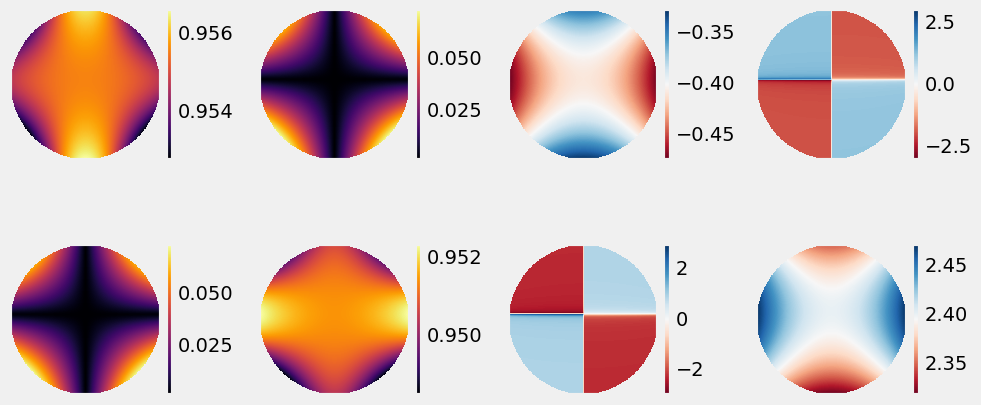

/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_64226/3139576435.py:11: RuntimeWarning: invalid value encountered in divide
  plot_jones_pupil(J,mask=mask/mask,kind='polar')


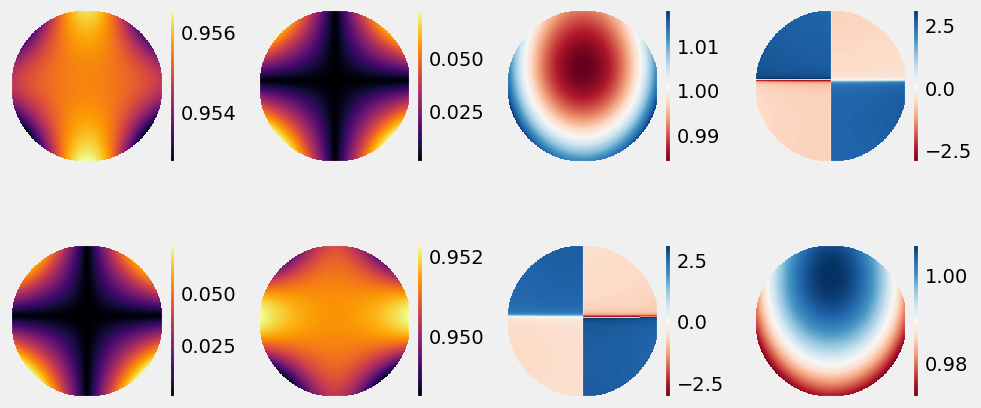

In [103]:
cost,_ = cost_function(a.ravel(),jones,cmplx_basis,aoi,wvl,n_list,return_jones=True)
print('cost before optimization = ',cost)
cost,J = cost_function(a_end.ravel(),jones,cmplx_basis,aoi,wvl,n_list,return_jones=True)
print('cost after optimization = ',cost)
x = np.linspace(-1,1,jones.shape[0])
x,y = np.meshgrid(x,x)
mask = np.zeros([jones.shape[0],jones.shape[0]])
# mask = mask.at[x**2 + y**2 < 1].set(1)
mask[x**2 + y**2 < 1] = 1
plot_jones_pupil(jones,mask=mask/mask,kind='polar')
plot_jones_pupil(J,mask=mask/mask,kind='polar')

cost value =  19.463775813351745


/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_64226/862534651.py:9: RuntimeWarning: invalid value encountered in divide
  plt.imshow(data*mask/mask,cmap=cm)


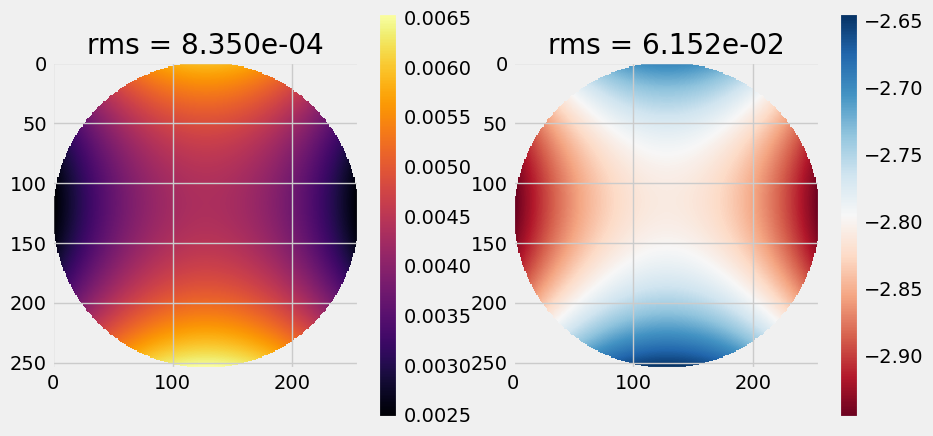

/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_64226/862534651.py:20: RuntimeWarning: invalid value encountered in divide
  plt.imshow(data*mask/mask,cmap=cm)


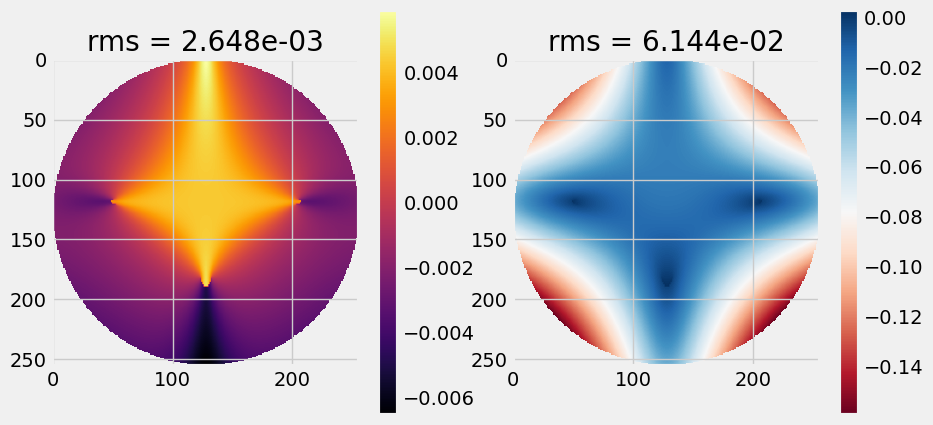

In [104]:
print('cost value = ',cost)
Do,Ro,T = compute_diattenuation_retardance_transmission(jones)
dlist = [Do,Ro]
cmap = ['inferno','RdBu','bone']
plt.figure(figsize=[15,5])
for i,(data,cm) in enumerate(zip(dlist,cmap)):
    plt.subplot(1,3,i+1)
    plt.title(f'rms = {np.std(data):.3e}')
    plt.imshow(data*mask/mask,cmap=cm)
    plt.colorbar()
plt.show()

D,R,T = compute_diattenuation_retardance_transmission(J)
dlist = [D,R]
cmap = ['inferno','RdBu','bone']
plt.figure(figsize=[15,5])
for i,(data,cm) in enumerate(zip(dlist,cmap)):
    plt.subplot(1,3,i+1)
    plt.title(f'rms = {np.std(data):.3e}')
    plt.imshow(data*mask/mask,cmap=cm)
    plt.colorbar()
plt.show()